# Homework 7 (50 points)

In this Homework, we will try to classify observations of space to be either stars, galaxies or quasars based on the RD14 from the Sloan Digital Sky Survey  (SDSS). The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested. 

http://www.sdss.org/
![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.


In this homework we will train several classifier to predict the class of a celestial object based on the observations (features). We will practice data prep, dimensionality reduction, model design and training, model comparison, and feature importance selection.

### Importing Libraries

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


## 1) Data Preparation (20 points)

We follow the following steps:
* read (1 point)
* clean (3 points)
* correlate (4 points)
* explore, spread of values (3 points)
* dimensionality reduction (9 points)

### 1.1 Data read
Read the pandas fata frame from the csv file "Skyserver_SQL2_27_2018.csv" and skip the first row.

**Task: read (1 point)**

Save a copy of the data frame just in case.

In [231]:
# answer
sdss_df = pd.read_csv('Skyserver_SQL2_27_2018.csv')

In [232]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


**Description of the data fields**

* objid = Object Identifier, self explanatory.
* ra = J2000 Right Ascension (r-band). Angular that is measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question.   https://en.wikipedia.org/wiki/Right_ascension
* dec = J2000 Declination (r-band). Angle that is measured north or south of the celestial equator, along the hour circle passing through the point in question. https://en.wikipedia.org/wiki/Declination



The Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further Information: http://astroweb.case.edu/ssm/ASTR620/mags.html 
* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit




Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. 
* run = Run Number, which identifies the specific scan. 
* rereun = Rerun Number, which specifies how the image was processed.
* camcol = Camera column, a number from 1 to 6, identifying the scanline within the run.
* field = Field number, which typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object): The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift: In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

* plate = plate number: Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

* mjd = MJD of observation, **Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.
* fiberid = fiber ID. The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### 1.2 Data Cleaning 

Basic stats about our dataset. 

**Task: Provide basic infor for the pandas dataframe head (0.5 point)**

In [233]:
# head
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


**Task: Find the data types of the database (floats, string, etc etc) using the ``info()`` function (0.5 point).**

In [234]:
# information
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Are there any obvious feature (or element of the dataframe) that should not impact our prediction?
 
**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.
The features **run**, **rerun**, **camcol** and **field** are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

**Task: Drop these columns in the pandas dataframe. (1 point)**

In [235]:
# answer
sdss_df = sdss_df.drop(columns=['objid','specobjid','run','rerun','camcol','field','plate','mjd','fiberid'])

In [236]:
sdss_df

,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590
...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,GALAXY,0.027583
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,GALAXY,0.117772
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,STAR,-0.000402
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,GALAXY,0.014019


Find our how many examples there are, how many attributes or feature, and the type of class.

In [237]:
# description
#data.describe()
print('There are', len(sdss_df), 'examples in this dataset.')
print('There are', len(sdss_df.columns), 'features for each example.')
print('The types of class are', sdss_df['class'].unique())

There are 10000 examples in this dataset.
There are 9 features for each example.
The types of class are ['STAR' 'GALAXY' 'QSO']


**Task: How many objects are in each class? (1 point)**

In [238]:
# Count the elements in each class
print('There are', sum(sdss_df['class'] == 'STAR'), 'objects in the class called STAR.');
print('There are', sum(sdss_df['class'] == 'GALAXY'), 'objects in the class called GALAXY.');
print('There are', sum(sdss_df['class'] == 'QSO'), 'objects in the class called QSO.')

There are 4152 objects in the class called STAR.
There are 4998 objects in the class called GALAXY.
There are 850 objects in the class called QSO.


The classes are "GALAXY", "STAR", and "QSO" (quasars). They are defined as strings, but we will convert them to integer in order to apply a loss function on the class labels during training. For this, we use the ``sklearn.preprocessing.LabelEncoder()`` function. We will do so and modify the classes in the dataframe. We should keep a copy of the original data frame to be safe.

In [239]:
sdss_df_save = sdss_df # make a copy of the original data before cleaning it. That works well when the data is small.

# encode class labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df['class'])
sdss_df['class'] = y_encoded
#  GALAXY = 0
# STAR = 1
# QSO = 2

### 1.3 Data correlations
Now let's find the most basic correlations among features. This can be done using the ``corr()`` function to apply on the pandas dataframe. Evaluate this function and comment on what feature is correlated among others. It is convenient to use the matplotlib function ``matshow()`` for clarity. ``seaborn`` is a python module that makes really pretty statistical plots https://seaborn.pydata.org/index.html#. Install it with ``pip`` and import it.

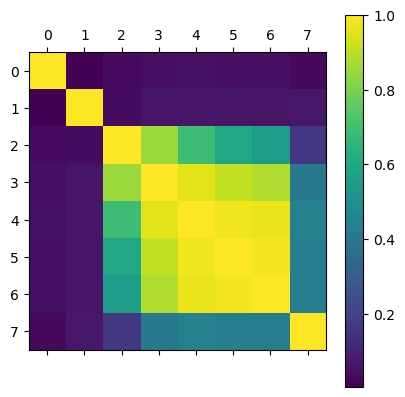

In [240]:
sdss_df = sdss_df.drop('class', axis=1)
correlations = sdss_df.corr()
plt.matshow(correlations)
plt.colorbar()

**Task: Plot the correlation matrix that can be called in the pandas dataframe. (2 points)**

Hints:

Use functions of ``heatmap``, add the labels in the axes. The colormap ``coolwarm`` is nice for divergent scales like correlations that vary between -1 and 1. The argument ``center=0`` ensures that the colormap is divergent from zero. Make sure to ignore the label column "class". Remember that dropping a column can be done in place ``sdss_df.drop('class', axis=1)``.

<AxesSubplot:>

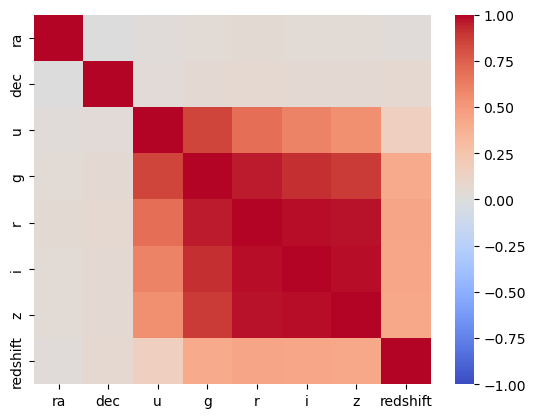

In [241]:
# answer
import seaborn as sns
sns.heatmap(correlations, cmap = 'coolwarm', center = 0, vmin = -1, vmax = 1)

**Task: Reproduce the same plot for each of the three classes. (1 point)**
You can select the values from the pandas dataframe by selecting over the column 'class'. 

Text(0.5, 1.0, 'Correlations in Class "Qso"')

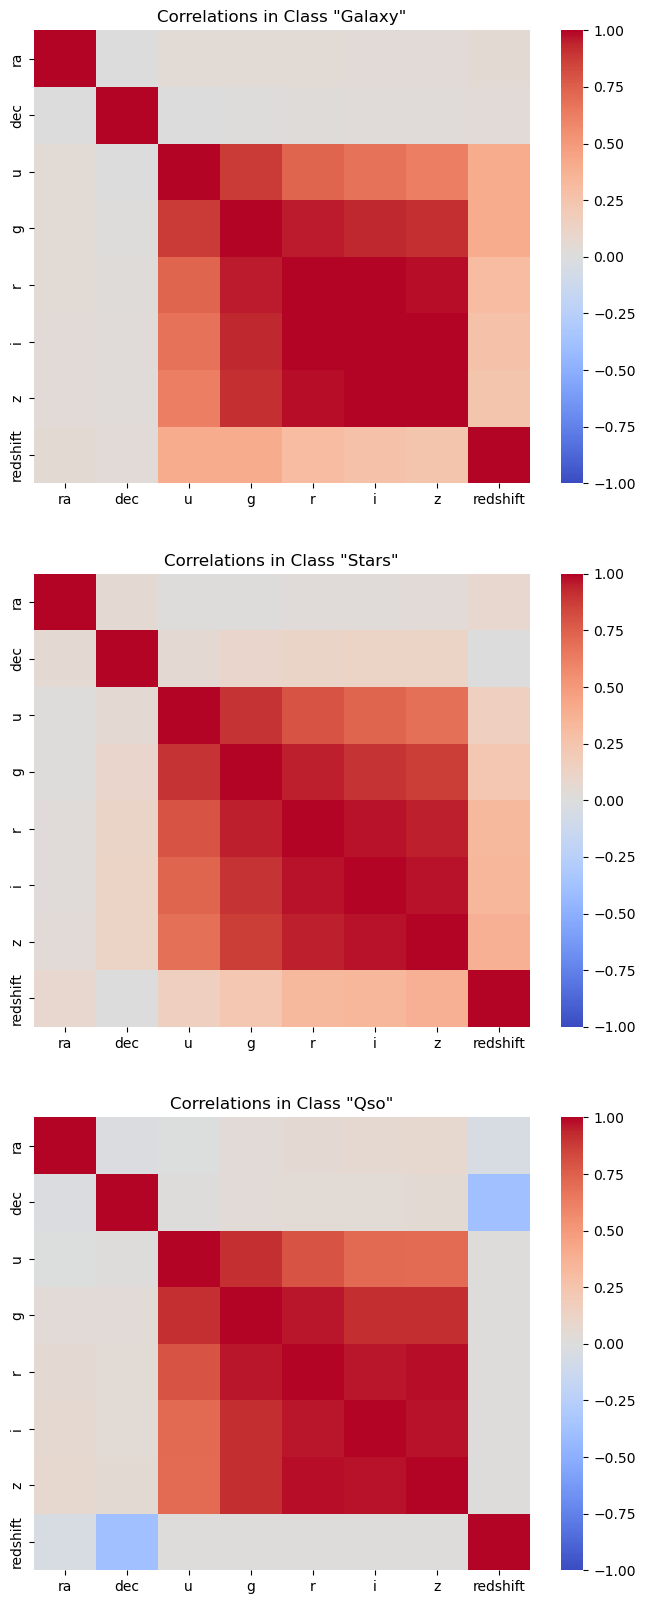

In [242]:
# make the same plot for Galaxies
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(8,20))

# "GALAXY" is label 0
galaxy_df = sdss_df.loc[sdss_df_save['class'] == 0]
correlations_galaxy = galaxy_df.corr()
c_galaxy = sns.heatmap(correlations_galaxy, cmap = 'coolwarm', center = 0, vmin = -1, vmax = 1, ax=ax1)
ax1.set_title('Correlations in Class "Galaxy"')

# Make the same plot for Stars (label 1)
stars_df = sdss_df.loc[sdss_df_save['class'] == 1]
correlations_stars = stars_df.corr()
c_stars = sns.heatmap(correlations_stars, cmap = 'coolwarm', center = 0, vmin = -1, vmax = 1, ax=ax2)
ax2.set_title('Correlations in Class "Stars"')

# make the same plots for quasars (label 2)
qso_df = sdss_df.loc[sdss_df_save['class'] == 2]
correlations_qso = qso_df.corr()
c_so = sns.heatmap(correlations_qso, cmap = 'coolwarm', center = 0, vmin = -1, vmax = 1, ax=ax3)
ax3.set_title('Correlations in Class "Qso"')

**Task: Can you comment on groups of observations that can be grouped together or that appear independent from each other given these correlations, and if there is any difference between the three celestial objects? (**1 point**)**

**'u', 'g', 'r', 'i', 'z' should be grouped together, which have apparent correlation with each other. z has highest positive correlation with the other 4 features in this group, and u has the lowest. Unlike other two classes, "Quasars" show stronger negative correlation between features 'dec' and 'redshift'.**   

### 1.5 Data exploration
Given the structure of the correlations, we will explore the values of the data.

#### 1.5.a. Distributions of redshift
"redshifting" happens when the source of light is becoming more distant to the receiver: the object is moving away from Earth. 

**Task: plot histograms for the 'redshift' feature column for each class (1 point).**

Text(0.5, 1.0, 'Redshift Histogram for "Qso"')

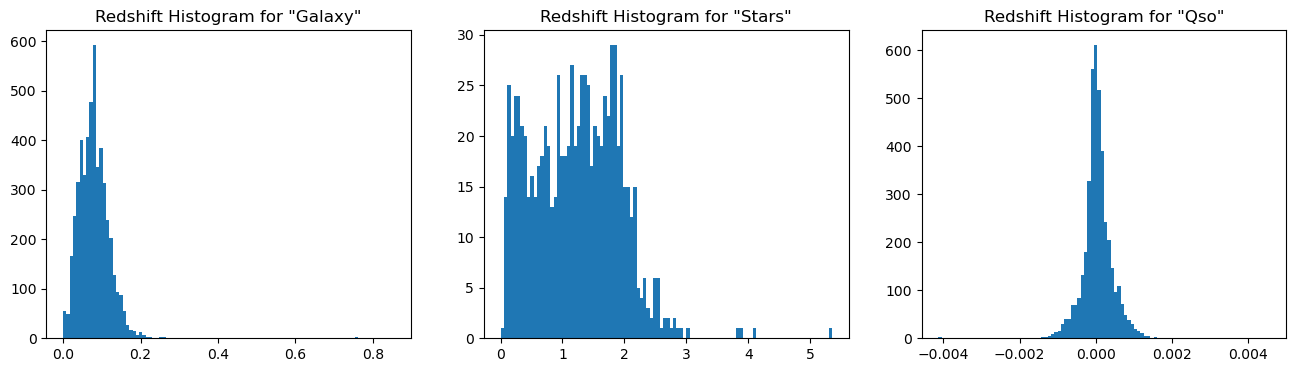

In [243]:
# answer
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
axes[0].hist(galaxy_df['redshift'],100); axes[0].set_title('Redshift Histogram for "Galaxy"')
axes[1].hist(stars_df['redshift'],100); axes[1].set_title('Redshift Histogram for "Stars"')
axes[2].hist(qso_df['redshift'],100); axes[2].set_title('Redshift Histogram for "Qso"')

**Task : Describe briefly the difference between the three histograms. (0.5 point)**

<!-- # answer -->
* **Star:** The histogram looks like a truncated zero-centered normal distribution. It looks like stars are both coming toward and away from the Earth.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075. It looks like galaxies are moving away from the Earth but at slow speeds.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers. This probably means that quasards are moving away from the earth with a diverse range of speeds.


#### 1.5.b. Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class. You can use the ``lmplot`` function in ``seaborn`` (https://seaborn.pydata.org/generated/seaborn.lmplot.html) to represent the sky view of these objects.

d:\Anaconda\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Equatorial coordinates')

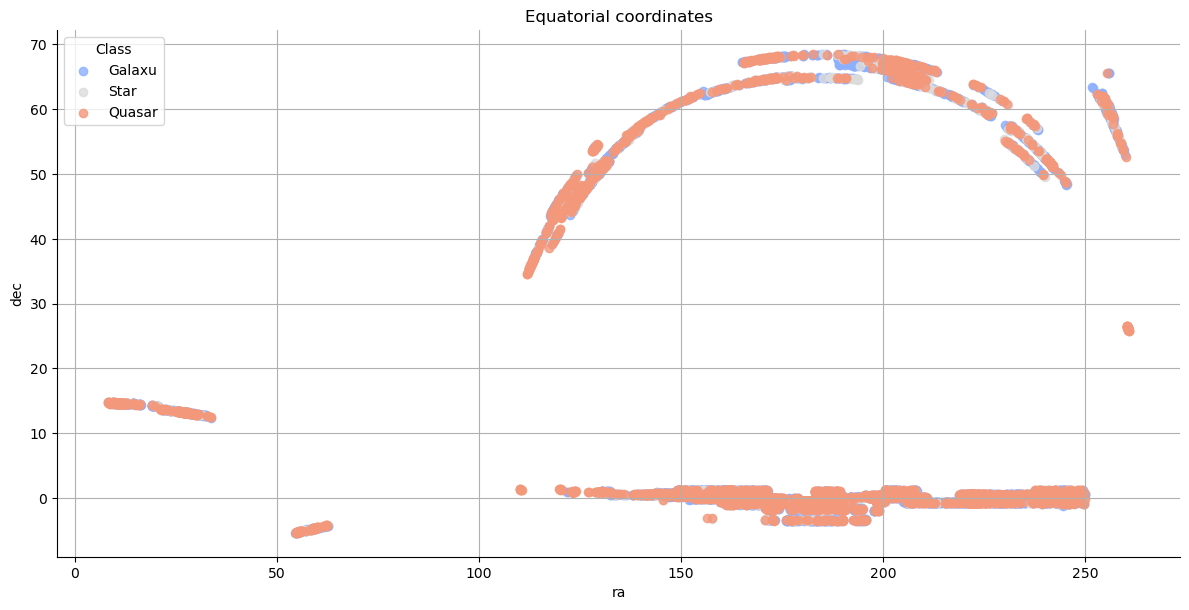

In [244]:
sns.lmplot(x='ra', y='dec', data=sdss_df_save, hue='class', fit_reg=False, palette='coolwarm', size=6, aspect=2,legend=False)
plt.legend(title='Class', loc='upper left', labels=['Galaxu', 'Star','Quasar'])
plt.grid(True)
plt.title('Equatorial coordinates')

**Task: do you see any obvious differences such that one could easily discriminate between the two coordinates? (0.5 point)**

**On this diagram, three classes have similar trend, and there is no obvious difference among these three classes on two coordinates.**

#### 1.5.c Filters - u,g,r,i,z 

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations. According to the correlation matrix, they are correlated for all three classes.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

**Task: Plot histograms and discuss why you expect these features to be correlated (1 points)**

Text(0.5, 1.0, 'Histogram of "z"')

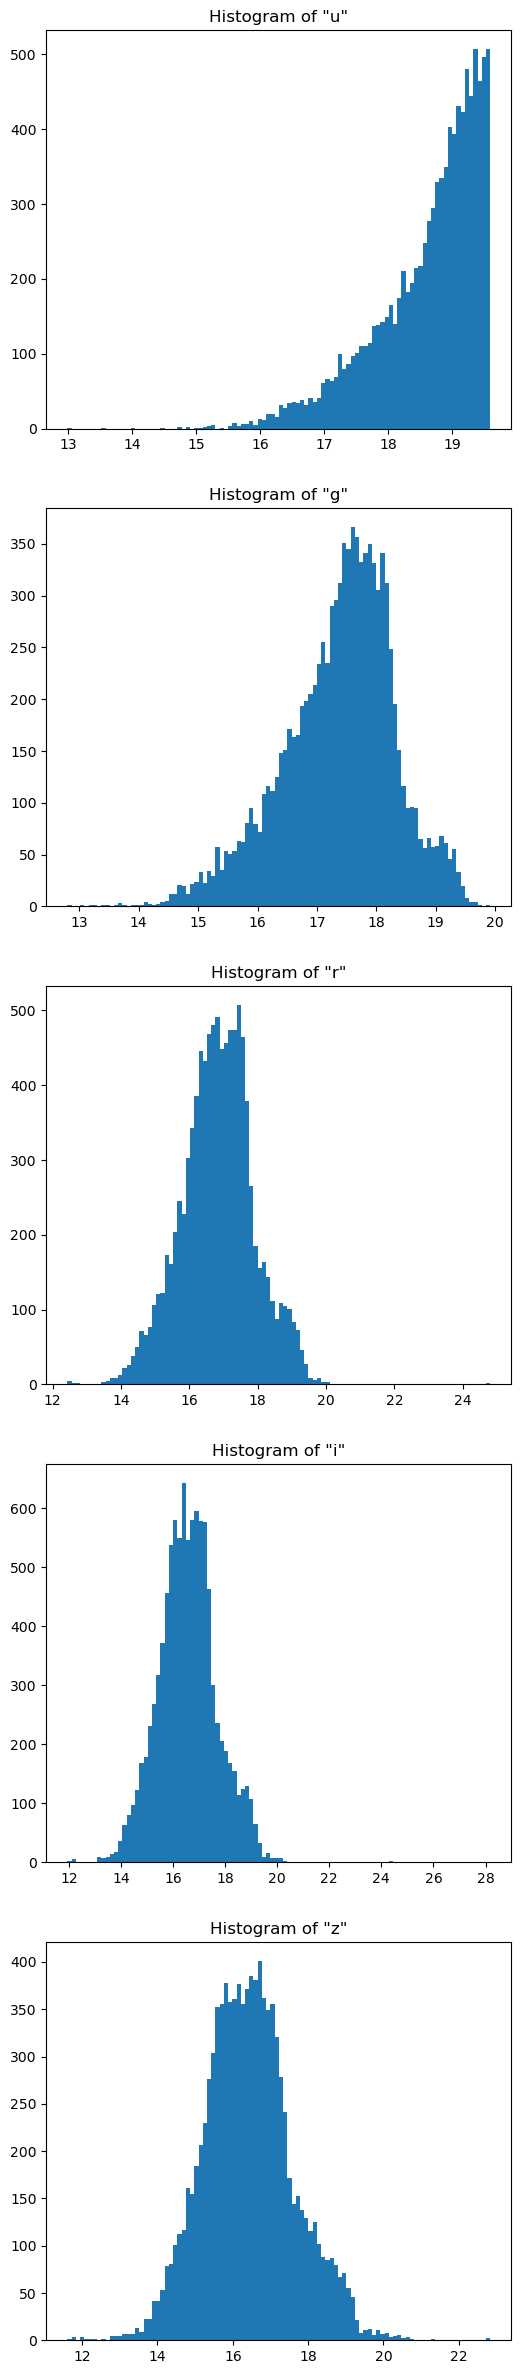

In [245]:
# Plot of histograms
#import warnings
#warnings.filterwarnings('ignore')


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,figsize=(6, 30))
ax1.hist(sdss_df_save['u'],100); ax1.set_title('Histogram of "u"')
ax2.hist(sdss_df_save['g'],100); ax2.set_title('Histogram of "g"')
ax3.hist(sdss_df_save['r'],100); ax3.set_title('Histogram of "r"')
ax4.hist(sdss_df_save['i'],100); ax4.set_title('Histogram of "i"')
ax5.hist(sdss_df_save['z'],100); ax5.set_title('Histogram of "z"')

**Based on the shape of these histograms, 'r', 'i', 'z' have similar shapes (normal distribution, similar spread and mean), which means they have stronger correlationship. 'g' (also normal distribution) has weaker correlation with others, and 'u'(left-skewed) has the weakest correlation with others.**

### 1.6 Data Dimensionality Reduction
At this point, we are left with 8 features: redshift, u, g, r, i, z, ra, and dec. Among these, the filters (u, g, r, i, z) are correlated to each other. There is therefore a potential for reducing the dimensions of the features using PCA on these 5 features.

We will use the skilearn function ``sklearn.decomposition.PCA()`` to fit and transform the data into the PC coordinates. Lets' first explore how many PCs we need. Fit the PCA function over the total number of filters. You will fit the PCA function over an array with the columns selected from the dataframe. 

**Task: Perform the PCA over a max number of PCs, output the explained variance ratio values, decide on an appropriate maximum number of PC to use (6 points)**

PCA(n_components=5)
[9.83416061e-01 9.07450580e-03 5.78663207e-03 1.72280162e-03
 3.66336782e-30]


Text(0.5, 1.0, 'Variance explained with each PC')

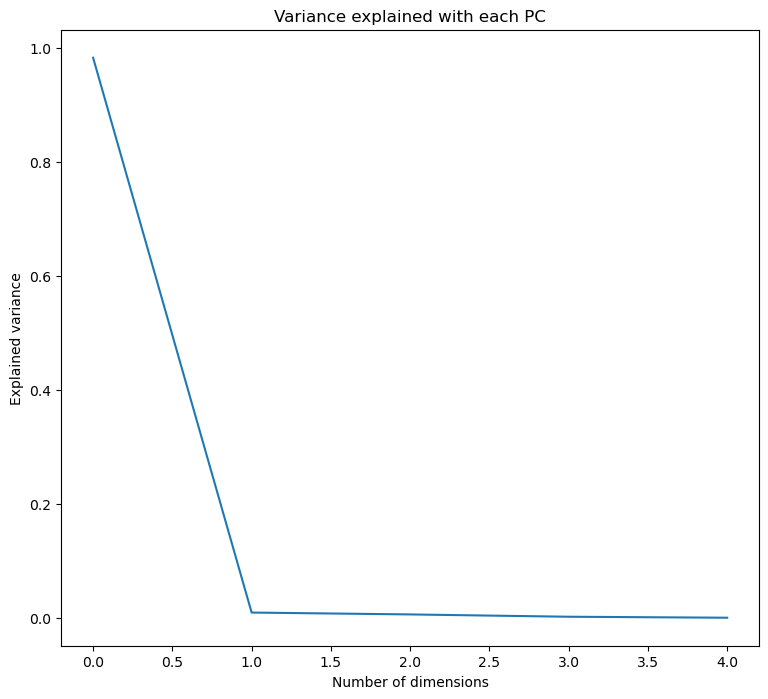

In [246]:
# anwer
from sklearn.decomposition import PCA
selected_col = sdss_df[['u','g','r','i','z']]
pca = PCA(n_components=5).fit(selected_col.transpose())
print(pca)

print(pca.explained_variance_ratio_)
fig = plt.figure(figsize=(9,8))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of dimensions')
plt.ylabel('Explained variance')
plt.title('Variance explained with each PC')


*Answer on how many PCs to use*



**About 98% of the variance is explained by the first PC. Based on the criterion that we need to select the minimum of PCs that would explain 95% of the variance, we can reduce the dimension only with one PC.**

We will now re-perform PCA with the number of PCs you found is most appropriate. Re-apply the fit-transform function. Update the dataframe by adding the PCA value(s) and dropping the columns of the 5 filter features.

**Task: PCA again, fit and transform, update the dataframe with the new feature(s) (3 points)**

In [249]:
# answer
# selected_col = sdss_df[['u','g','r','i','z']]
pca = PCA(n_components=1).fit(selected_col)
print(pca)
col_pca = pca.transform(selected_col)
col_new = pca.inverse_transform(col_pca)
sdss_df['u'] = col_new[:,0]
sdss_df['g'] = col_new[:,1]
sdss_df['r'] = col_new[:,2]
sdss_df['i'] = col_new[:,3]
sdss_df['z'] = col_new[:,4]
sdss_df


PCA(n_components=1)


,ra,dec,u,g,r,i,z,redshift
0,183.531326,0.089693,18.214375,16.753034,16.120080,15.823309,15.631042,-0.000009
1,183.598370,0.135285,18.566756,17.291548,16.747334,16.484834,16.319994,-0.000055
2,183.680207,0.126185,18.968017,17.904762,17.461597,17.238123,17.104514,0.123111
3,183.870529,0.049911,18.230789,16.778117,16.149297,15.854122,15.663132,-0.000111
4,183.883288,0.102557,18.391159,17.023198,16.434764,16.155186,15.976678,0.000590
...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.679264,17.463484,16.947603,16.696045,16.539962,0.027583
9996,131.306083,51.671341,18.688994,17.478354,16.964923,16.714311,16.558985,0.117772
9997,131.552562,51.666986,19.017221,17.979957,17.549183,17.330494,17.200715,-0.000402
9998,131.477151,51.753068,18.993405,17.943560,17.506788,17.285783,17.154150,0.014019


## 2) Machine Learning Models (26 points)

We will now train different models on this dataset. We have a total of 8 features, 3 classes, and 10,000 samples. We will use K-Nearest Neighbors, Naive Bayes, Random Forest, Support Vector Machine, Multi Layer Perceptron.

We now follow a normal machine learning workflow:
* Feature scaling (2 points)
* Train/test set split (2 points)
* Model design, training, testing (15 points)
* Model comparisons, pick your winner, discuss feature importance using Random Forest. (10 points)

### 2.1 Feature Scaling
Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster. You can scale the features only by dropping the "class" column without modifying the dataframe in place, using the pandas function ``drop()``.

**Task: Scale just the features (2 points)**

In [250]:
sdss_df

,ra,dec,u,g,r,i,z,redshift
0,183.531326,0.089693,18.214375,16.753034,16.120080,15.823309,15.631042,-0.000009
1,183.598370,0.135285,18.566756,17.291548,16.747334,16.484834,16.319994,-0.000055
2,183.680207,0.126185,18.968017,17.904762,17.461597,17.238123,17.104514,0.123111
3,183.870529,0.049911,18.230789,16.778117,16.149297,15.854122,15.663132,-0.000111
4,183.883288,0.102557,18.391159,17.023198,16.434764,16.155186,15.976678,0.000590
...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.679264,17.463484,16.947603,16.696045,16.539962,0.027583
9996,131.306083,51.671341,18.688994,17.478354,16.964923,16.714311,16.558985,0.117772
9997,131.552562,51.666986,19.017221,17.979957,17.549183,17.330494,17.200715,-0.000402
9998,131.477151,51.753068,18.993405,17.943560,17.506788,17.285783,17.154150,0.014019


In [251]:
# answer
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(sdss_df)
features_scaled = scaler.transform(sdss_df)

In [252]:
print(features_scaled)

[[6.93832273e-01 7.40254729e-02 3.85886269e-01 ... 3.85886269e-01
  3.85886269e-01 7.70273543e-04]
 [6.94097640e-01 7.46422070e-02 4.48109611e-01 ... 4.48109611e-01
  4.48109611e-01 7.61699432e-04]
 [6.94421555e-01 7.45191099e-02 5.18964263e-01 ... 5.18964263e-01
  5.18964263e-01 2.37490694e-02]
 ...
 [4.88097418e-01 7.71724013e-01 5.27652687e-01 ... 5.27652687e-01
  5.27652687e-01 6.96997371e-04]
 [4.87798936e-01 7.72888457e-01 5.23447184e-01 ... 5.23447184e-01
  5.23447184e-01 3.38840082e-03]
 [4.88542500e-01 7.73595116e-01 4.12978041e-01 ... 4.12978041e-01
  4.12978041e-01 2.28730132e-02]]


### 2.2 Test, train, validation data sets.
**Task: Split the data into a training and a test part.  (2 points)**

The models will be trained on the training data set and tested on the test data set

In [253]:
# answer
sdss_df = sdss_df_save # make the dataset contain 'class' column again.

from sklearn.model_selection import train_test_split
print(f"There are {sdss_df.shape[0]} data samples")
y = sdss_df['class']
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.33, shuffle=True)

There are 10000 data samples


Computation time is important to account for when scaling up the data set and the model size. You can evaluate the relative computational time using the function ``time.perf_counter()`` to evaluate the absolute time. Then compare the computational time by making the difference between two time stamps:

``t1=time.perf_counter()``

``t2=time.perf_counter()``

``tcomp = t2 - t1``

We will also assess the model performance of these multi-class classifiers. We will evaluate the average of the scores over the 3 class labels.

In [254]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
label_name = ['Star','Galaxy','Quasar']

In the following, we will be testing over several classifiers. Follow the steps:
1. model definition/design
2. training
3. prediction on test
4. evaluation: a) print the classification_report; b) save the precision, recall, fscore and accuracy in variables

### 2.3.a K Nearest Neighbors (3 points)
Check out the function arguments and definition here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [255]:
#answer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
print("Classifying using K-nearest Neighbors")
t1 = time.perf_counter()
# model design
knn_clf = KNeighborsClassifier()

# training
knn_clf.fit(X_train, y_train)

# evaluation on test
knn_prediction = knn_clf.predict(X_test)
t2 = time.perf_counter()
knn_tcomp = t2-t1
print('Absolute time for processing:', knn_tcomp, 'seconds')

# print the classification report
print(classification_report(y_test, knn_prediction, target_names=label_name))

# save values of precision, recall, fscore, accuracy.
knn_precision = metrics.precision_score(y_test, knn_prediction, average='macro')
print('K Nearest Neighbors Precision Score:', knn_precision)
knn_recall = metrics.recall_score(y_test, knn_prediction, average='macro')
print('K Nearest Neighbors Recall Score:', knn_recall)
knn_fscore = metrics.f1_score(y_test, knn_prediction, average='macro')
print('K Nearst Neighbors f1 Score:', knn_fscore)
knn_accuracy = metrics.accuracy_score(y_test, knn_prediction)
print('K Nearest Neighbors Accuracy:', knn_accuracy)

Classifying using K-nearest Neighbors
Absolute time for processing: 0.14502520000678487 seconds
              precision    recall  f1-score   support

        Star       0.84      0.81      0.83      1698
      Galaxy       0.98      0.84      0.91       276
      Quasar       0.77      0.83      0.80      1326

    accuracy                           0.82      3300
   macro avg       0.86      0.83      0.84      3300
weighted avg       0.82      0.82      0.82      3300

K Nearest Neighbors Precision Score: 0.8649403684628085
K Nearest Neighbors Recall Score: 0.8279333963160882
K Nearst Neighbors f1 Score: 0.8442030357884903
K Nearest Neighbors Accuracy: 0.8209090909090909


### 2.3.b Naive Bayes (3 points)
Check out the sklearn tutorial pages here: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes. We propose to use the Gaussian Naive Bayes.

Naive Bayes assumes the data to be normally distributed which can be achieved by scaling using the MaxAbsScaler. For this example then we will use the unscaled data, then rescale it.

In [256]:
# answer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MaxAbsScaler
print("Classifying using Gaussian Naive Bayes")

# model design
gnb_clf = GaussianNB()

# re-scale the data
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(sdss_df.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sdss_df['class'], test_size=0.33)

# training
t1 = time.perf_counter()
gnb_clf.fit(X_train_gnb, y_train_gnb)

# evaluation
gnb_prediction = gnb_clf.predict(X_test_gnb)
t2 = time.perf_counter()
gnb_tcomp = t2-t1
print('Absolute time for processing:', gnb_tcomp, 'seconds')

# evaluation: 
# print the classification report
print(classification_report(y_test_gnb, gnb_prediction, target_names=label_name))

# save values of precision, recall, fscore, accuracy.
gnb_precision = metrics.precision_score(y_test_gnb, gnb_prediction, average='macro')
print('Naive Bayes Precision Score:', gnb_precision)
gnb_recall = metrics.recall_score(y_test_gnb, gnb_prediction, average='macro')
print('Naive Bayes Recall Score:', gnb_recall)
gnb_fscore = metrics.f1_score(y_test_gnb, gnb_prediction, average='macro')
print('Naive Bayes f1 Score:', gnb_fscore)
gnb_accuracy = metrics.accuracy_score(y_test_gnb, gnb_prediction)
print('Naive Bayes Accuracy:', gnb_accuracy)

Classifying using Gaussian Naive Bayes
Absolute time for processing: 0.008705600019311532 seconds
              precision    recall  f1-score   support

        Star       0.99      0.97      0.98      1633
      Galaxy       0.85      0.95      0.90       255
      Quasar       0.99      0.99      0.99      1412

    accuracy                           0.98      3300
   macro avg       0.95      0.97      0.96      3300
weighted avg       0.98      0.98      0.98      3300

Naive Bayes Precision Score: 0.946327916910297
Naive Bayes Recall Score: 0.9710015223132449
Naive Bayes f1 Score: 0.9578853154566683
Naive Bayes Accuracy: 0.9803030303030303


### 2.3.c Random Forest Classifier (2 points)
Check out the tutorial page here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [257]:
# answer
from sklearn.ensemble import RandomForestClassifier
print("Classifying using Random Forest Classifiers")

# model design
rf_clf = RandomForestClassifier()

# training
t1 = time.perf_counter()
rf_clf.fit(X_train, y_train)

# evaluation
rf_prediction = rf_clf.predict(X_test)
t2 = time.perf_counter()
rf_tcomp = t2-t1
print('Absolute time for processing:', rf_tcomp, 'seconds')

# evaluation: 
# print the classification report
print(classification_report(y_test, rf_prediction, target_names=label_name))

# save values of precision, recall, fscore, accuracy.
rf_precision = metrics.precision_score(y_test, rf_prediction, average='macro')
print('Random Forest Precision Score:', rf_precision)
rf_recall = metrics.recall_score(y_test, rf_prediction, average='macro')
print('Random Forest Recall Score:', rf_recall)
rf_fscore = metrics.f1_score(y_test, rf_prediction, average='macro')
print('Random Forest f1 Score:', rf_fscore)
rf_accuracy = metrics.accuracy_score(y_test, rf_prediction)
print('Random Forest Accuracy:', rf_accuracy)


Classifying using Random Forest Classifiers
Absolute time for processing: 0.9942466999928001 seconds
              precision    recall  f1-score   support

        Star       0.99      0.99      0.99      1698
      Galaxy       0.97      0.93      0.95       276
      Quasar       0.99      1.00      1.00      1326

    accuracy                           0.99      3300
   macro avg       0.98      0.97      0.98      3300
weighted avg       0.99      0.99      0.99      3300

Random Forest Precision Score: 0.9833787282224558
Random Forest Recall Score: 0.972961732762642
Random Forest f1 Score: 0.9780368444102329
Random Forest Accuracy: 0.9881818181818182


### 2.3.d Support Vector Machine Classifier (2 points)
Check out the sklearn information page here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [258]:
# answer
from sklearn.svm import SVC
print("Classifying using Support Vector Machine Classfiers")

# model design
svc_clf = SVC()

# training
t1 = time.perf_counter()
svc_clf.fit(X_train, y_train)

# evaluation
svc_prediction = svc_clf.predict(X_test)
t2 = time.perf_counter()
svc_tcomp = t2-t1
print('Absolute time for processing:', svc_tcomp, 'seconds')

# evaluation: 
# print the classification report
print(classification_report(y_test, svc_prediction, target_names=label_name))

# save values of precision, recall, fscore, accuracy.
svc_precision = metrics.precision_score(y_test, svc_prediction, average='macro')
print('Support Vector Machine Precision Score:', svc_precision)
svc_recall = metrics.recall_score(y_test, svc_prediction, average='macro')
print('Support Vector Machine Recall Score:', svc_recall)
svc_fscore = metrics.f1_score(y_test, svc_prediction, average='macro')
print('Support Vector Machine f1 Score:', svc_fscore)
svc_accuracy = metrics.accuracy_score(y_test, svc_prediction)
print('Support Vector Machine Accuracy:', svc_accuracy)


Classifying using Support Vector Machine Classfiers
Absolute time for processing: 3.6947915999917313 seconds
              precision    recall  f1-score   support

        Star       0.88      0.82      0.85      1698
      Galaxy       0.98      0.84      0.91       276
      Quasar       0.79      0.88      0.83      1326

    accuracy                           0.85      3300
   macro avg       0.88      0.85      0.86      3300
weighted avg       0.85      0.85      0.85      3300

Support Vector Machine Precision Score: 0.883228857014787
Support Vector Machine Recall Score: 0.8476895818382267
Support Vector Machine f1 Score: 0.8625781293346484
Support Vector Machine Accuracy: 0.8454545454545455


### 2.3.e Multi-Layer Perceptron (3 points)

Check out the information page here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [259]:
# answer
from sklearn.neural_network import MLPClassifier
print("Classifying using Multi Layer Perceptron Classifier")


# model design
mlp_clf = MLPClassifier()

# training
t1 = time.perf_counter()
mlp_clf.fit(X_train, y_train)

# evaluation
mlp_prediction = mlp_clf.predict(X_test)
t2 = time.perf_counter()
mlp_tcomp = t2-t1
print('Absolute time for processing:', mlp_tcomp, 'seconds')

# evaluation: 
# print the classification report
print(classification_report(y_test, mlp_prediction, target_names=label_name))

# save values of precision, recall, fscore, accuracy.
mlp_precision = metrics.precision_score(y_test, mlp_prediction, average='macro')
print('Multi-layer Perceptron Precision Score:', mlp_precision)
mlp_recall = metrics.recall_score(y_test, mlp_prediction, average='macro')
print('Multi-layer Perceptron Recall Score:', mlp_recall)
mlp_fscore = metrics.f1_score(y_test, mlp_prediction, average='macro')
print('Multi-layer Perceptron f1 Score:', mlp_fscore)
mlp_accuracy = metrics.accuracy_score(y_test, mlp_prediction)
print('Multi-layer Perceptron Accuracy:', mlp_accuracy)

Classifying using Multi Layer Perceptron Classifier
Absolute time for processing: 5.6684602000168525 seconds
              precision    recall  f1-score   support

        Star       0.99      0.97      0.98      1698
      Galaxy       0.97      0.92      0.94       276
      Quasar       0.97      1.00      0.99      1326

    accuracy                           0.98      3300
   macro avg       0.98      0.96      0.97      3300
weighted avg       0.98      0.98      0.98      3300

Multi-layer Perceptron Precision Score: 0.9764397140448487
Multi-layer Perceptron Recall Score: 0.9635295361235915
Multi-layer Perceptron f1 Score: 0.9696763188581602
Multi-layer Perceptron Accuracy: 0.9796969696969697


d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 2.4 Model performance and comparison 

### 2.4.a Confusion Matrix and interpretation

**Task: Plot the confusion matrix (2 points)**

Use the sklearn function ``plot_confusion_matrix``. Find help here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html. We tested 5 models, make suplots, set the title on each subplots.


d:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
d:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
d:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_prediction

Text(0.5, 1.0, 'Multi-layer Perceptron')

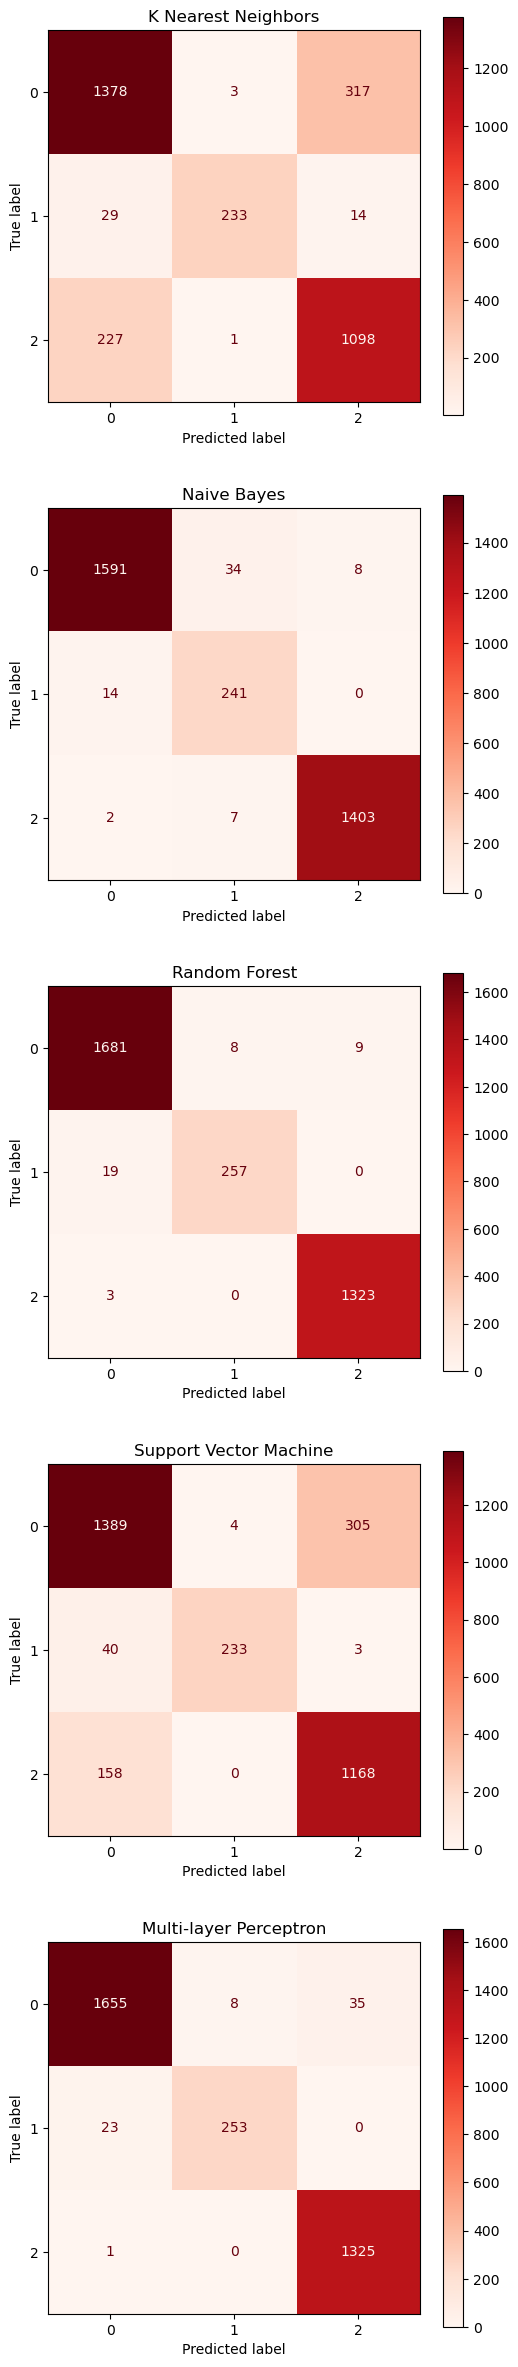

In [260]:
# plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix
clf = [knn_clf, gnb_clf, rf_clf, svc_clf, mlp_clf]
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,figsize=(6, 30))
plot_confusion_matrix(knn_clf, X_test, y_test, ax=ax1, cmap='Reds')
ax1.set_title('K Nearest Neighbors')
plot_confusion_matrix(gnb_clf, X_test_gnb, y_test_gnb, ax=ax2, cmap='Reds')
ax2.set_title('Naive Bayes')
plot_confusion_matrix(rf_clf, X_test, y_test, ax=ax3, cmap='Reds')
ax3.set_title('Random Forest')
plot_confusion_matrix(svc_clf, X_test, y_test, ax=ax4, cmap='Reds')
ax4.set_title('Support Vector Machine')
plot_confusion_matrix(mlp_clf, X_test, y_test, ax=ax5, cmap='Reds')
ax5.set_title('Multi-layer Perceptron')


**Task: Comment on what you see the best classifier is likely to be (1 point).** You can also comment on the misclassification and confusion rates.

**According to confusion matrics, Random Forest Classifier is the best classifier in this task.**

### 2.4.a K Fold Cross Validation
We will now perform k fold cross valdiation for the classifiers. We use the function ``cross_val_score`` on each ewstimator, on the training set, with 10 folds, and use accuracy as a score metric.

**Task: perform the cross validation over K folds, output the mean and standard deviation of the accuracy (3 points)**

In [261]:
from sklearn.model_selection import cross_val_score
# print("K-nearest neighbors Mean:", scores_knn.mean(),"Standard Deviation:", scores_knn.std())

knn_cv = cross_val_score(knn_clf, X_train, y_train, cv=10)
print("K-nearest neighbors Mean:", knn_cv.mean(),"Standard Deviation:", knn_cv.std())
gnb_cv = cross_val_score(gnb_clf, X_train_gnb, y_train_gnb, cv=10)
print("Naive Bayes Mean:", gnb_cv.mean(),"Standard Deviation:", gnb_cv.std())
rf_cv = cross_val_score(rf_clf, X_train, y_train, cv=10)
print("Random Forest Mean:", rf_cv.mean(),"Standard Deviation:", rf_cv.std())
svc_cv = cross_val_score(svc_clf, X_train, y_train, cv=10)
print("Support Vector Machine Mean:", svc_cv.mean(),"Standard Deviation:", svc_cv.std())
mlp_cv = cross_val_score(mlp_clf, X_train, y_train, cv=10)
print("Multi-layer Perceptron Mean:", mlp_cv.mean(),"Standard Deviation:", mlp_cv.std())

K-nearest neighbors Mean: 0.8262686567164179 Standard Deviation: 0.010704729001218579
Naive Bayes Mean: 0.9797014925373133 Standard Deviation: 0.0053063847267555905
Random Forest Mean: 0.9861194029850745 Standard Deviation: 0.0029133166113347827
Support Vector Machine Mean: 0.86 Standard Deviation: 0.013692352168572793


d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer

Multi-layer Perceptron Mean: 0.9702985074626864 Standard Deviation: 0.0046460843033652


d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**Task: Which method won the Xval test (1 point) ?**

see the cell below

**"Random Forest" is the best one.**

### 2.4.c And the winner is ...

Let's compare the results. 
**Task: Create a pandas dataframe with all of the performance metrics, including the results from K-fold cross validation. (2 points)**

In [262]:
# create data frame
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Random Forest', 'SVC','ANN'],
    'Accuracy': [knn_accuracy, gnb_accuracy, rf_accuracy, svc_accuracy, mlp_accuracy],
    'Precision': [knn_precision, gnb_precision, rf_precision, svc_precision, mlp_precision],
    'Recall': [knn_recall, gnb_recall, rf_precision, svc_precision, mlp_precision],
    'Fscore': [knn_fscore, gnb_fscore, rf_fscore, svc_fscore, mlp_fscore],
    'Kfold_accuracy_mean': [knn_cv.mean(), gnb_cv.mean(), rf_cv.mean(), svc_cv.mean(), mlp_cv.mean()],
    'Kfold_accuracy_std': [knn_cv.std(), gnb_cv.std(), rf_cv.std(), svc_cv.std(), mlp_cv.std()]})
# sort values by the Fscore with the greatest value first.
results.sort_values(by=['Fscore'], ascending=False)


,Model,Accuracy,Precision,Recall,Fscore,Kfold_accuracy_mean,Kfold_accuracy_std
2,Random Forest,0.988182,0.983379,0.983379,0.978037,0.986119,0.002913
4,ANN,0.979697,0.976440,0.976440,0.969676,0.970299,0.004646
1,Naive Bayes,0.980303,0.946328,0.971002,0.957885,0.979701,0.005306
3,SVC,0.845455,0.883229,0.883229,0.862578,0.860000,0.013692
0,KNN,0.820909,0.864940,0.827933,0.844203,0.826269,0.010705


**Task: Comment on the accuracy and performance and choose a winner. (1 point)**

see the cell below

**Based on the criteria matrix above, "Random Forest Classifier" is the winner in every aspect.**

## 3 Summary (4 points)

### 3.1 Feature Importance using Random Forest Classifier

Decision Trees have the unique property of being able to order features by their ability to split between the classes. If some features dominate over other in the predictive power of classes, one can further reduce the dimension of the features for additional analysis. The vector of feature importance is the module ``rfc.feature_importances_``, sorted with ascending importance. Store the vector of importance .

**Task: plot a bar plot using the function ``matplotlib.pyplot.bar``. (2 points)**

Text(0, 0.5, 'Frequency')

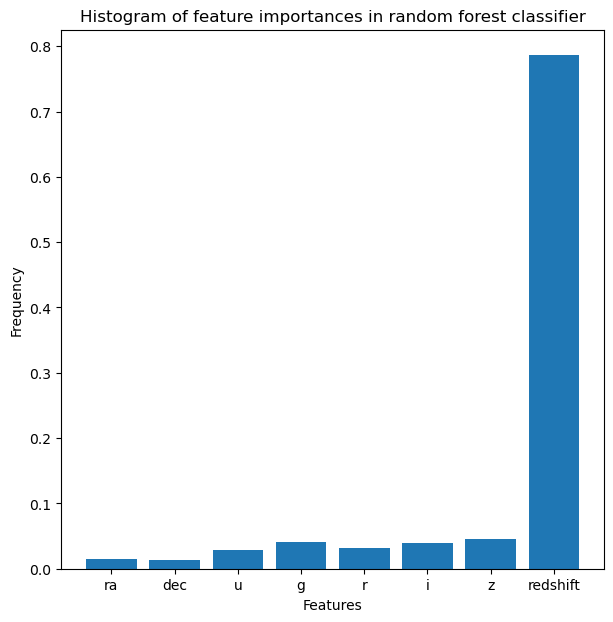

In [263]:
# answer
# vector of importance
# vector of features
features = sdss_df.drop(columns=['class'])
feature_list = list(features.columns)
features = np.array(features)
rf_importances = list(rf_clf.feature_importances_)
rf_importances = [(feature, round(rf_importances, 3)) for feature, rf_importances in zip(feature_list, rf_importances)]
sorted_importances = pd.DataFrame(rf_importances)
sorted_importances.columns = ['Feature', 'Importance']
sorted_importances.sort_values(by=['Importance'], ascending=True)

sorted_importances

fig = plt.figure(figsize=(7,7))
plt.bar(sorted_importances['Feature'], sorted_importances['Importance'])
plt.title('Histogram of feature importances in random forest classifier')
plt.xlabel('Features')
plt.ylabel('Frequency')

**Task: What are the top three features (1 point)?**

**The top three features are "redshift", "z", and "i". "redshift" is dominant in importance.**

In this notebook, you have learned that redshift was the best predictor of what object you are observing. Now, did you actualy need to do this all to find this out? Probably not if you were an astrophysicist! But hey, we are not. So great job!

**Task: Briefly comment on what you have learned (1 point)**

see the cell below

**- I gained a holistic sense of the architecture of acquiring data, processing data, modeling data, and evaluating models.**

**- I learned how to check the correlations among different features and conduct PCA.**

**- I learned how to evaluate and choose appropriate models for one ML task.**

**- I got some ideas that I can derive another project by using similar logic in this homework.** 

## Bonus questions (5 points)


Perform hyperparameter tuning and ensemble learning to improve on the classification performance.

In [264]:
# answer below

<!-- answer -->